In [41]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import math
import scipy
from scipy import signal, interpolate
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt


from pathlib import Path
from scipy.io import wavfile

In [42]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))
bucket = 'pacific-sound-256khz-2021'
bucket = 'pacific-sound-256khz-2021'
filename = '09/MARS_20210915_070829.wav'
url = f'https://{bucket}.s3.amazonaws.com/{filename}'

In [43]:
print(f'Reading data from {url}')
x, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')

Reading data from https://pacific-sound-256khz-2021.s3.amazonaws.com/09/MARS_20210915_070829.wav


KeyboardInterrupt: 

In [44]:
filename = 'MARS_20180101_092406.wav'
audio_dir = Path('media', 'audio') 
x, sample_rate = sf.read(Path(audio_dir, filename))

## Produce a spectrogram

### Calibrated Spectrum Levels

### Calibration metadata
Frequency-dependent hydrophone sensitivity data are defined in the following files, one for each deployment:
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

### Compute spectrogram




In [45]:
# convert scaled voltage to volts
v = x*3
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 1  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

600 segments of length 1 seconds in 600.0 seconds of audio


In [46]:
lenfft_input = 2**int(np.ceil(np.log2(sample_rate)))
print(lenfft_input)
#
# initialize empty LTSA
nfreq = int(lenfft_input/2+1)
sg_input = np.empty((nfreq, nseg), float)
sg_input.shape

262144


(131073, 600)

In [47]:
# get window
w_input = scipy.signal.get_window('blackman',sample_rate)
window_correction = np.mean(np.square(w_input))
#
numDataPoints_input = int(sample_rate*spa)
#
Ind_keep = np.arange(0, int(lenfft_input/2)+1)
f_input = (Ind_keep/lenfft_input) * sample_rate
#
# Calculate spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
#  f,psd = scipy.signal.welch(v[cstart:cend], fs=sample_rate, window=w_input, nfft=sample_rate)
  psd_input = np.square(np.absolute(np.fft.fft(np.multiply(v[cstart:cend],w_input), n=lenfft_input)))/(numDataPoints_input*window_correction)/sample_rate
  psd_input_log10 = 10*np.log10(psd_input[Ind_keep])
  sg_input[:,x] = psd_input_log10
  if (x == 0):
    psd_input_check = psd_input
    print("Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:")
    print(np.mean(np.square(v[cstart:cend])))
    print(sum(psd_input_check)*(sample_rate/lenfft_input))

Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:
0.00012321438119918825
0.00012466339382223948


### Apply calibration
Frequency-dependent hydrophone sensitivity data are reported in the json files identified above.  This example file is from the second hydrophone deployment, for which the calibration data are manually entered below.  Note that the lowest measured value, at 250 Hz, is assumed to cover lower frequencies and repeated as a value at 0 Hz to allow interpolation to the spectrogram output frequencies across the full frequency range.



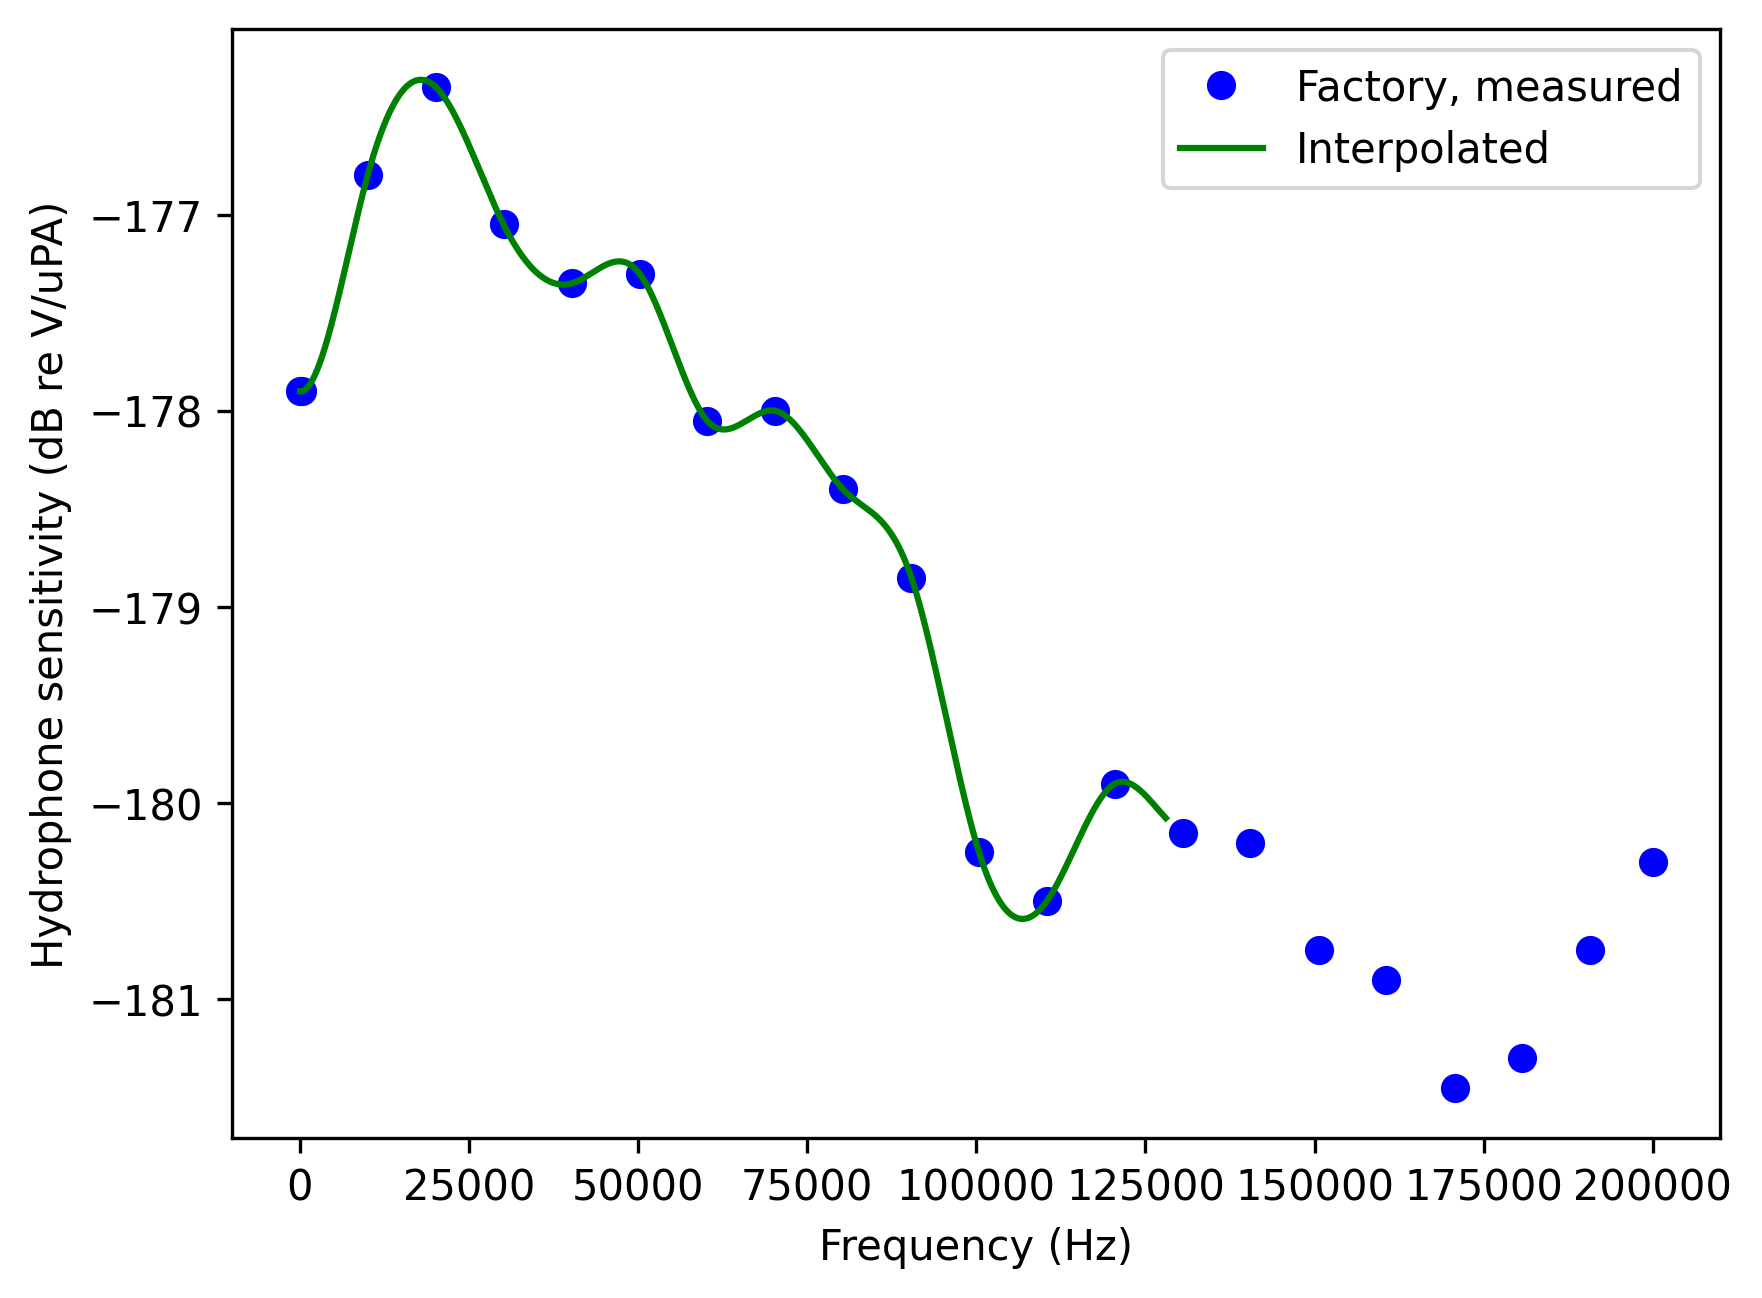

In [48]:
# define hydrophone calibration data
calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

# interpolate to the frequency resolution of the spectrogram
tck = interpolate.splrep(calfreq, calsens, s=0)
isens = interpolate.splev(f_input, tck, der=0)
plt.figure(dpi=300)
im = plt.plot(calfreq,calsens,'bo',f_input,isens,'g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hydrophone sensitivity (dB re V/uPA)')
plt.legend(['Factory, measured', 'Interpolated'])


In [49]:
# replicate interpolated sensitivity
isensg = np.transpose(np.tile(isens,[nseg,1]))
isensg.shape

(131073, 600)

In [50]:
sg_input.shape

(131073, 600)

### Plot the calibrated spectrogram

Text(0.5, 1.0, 'Calibrated spectrum levels (dB) of the 256 kHz sample-rate input data')

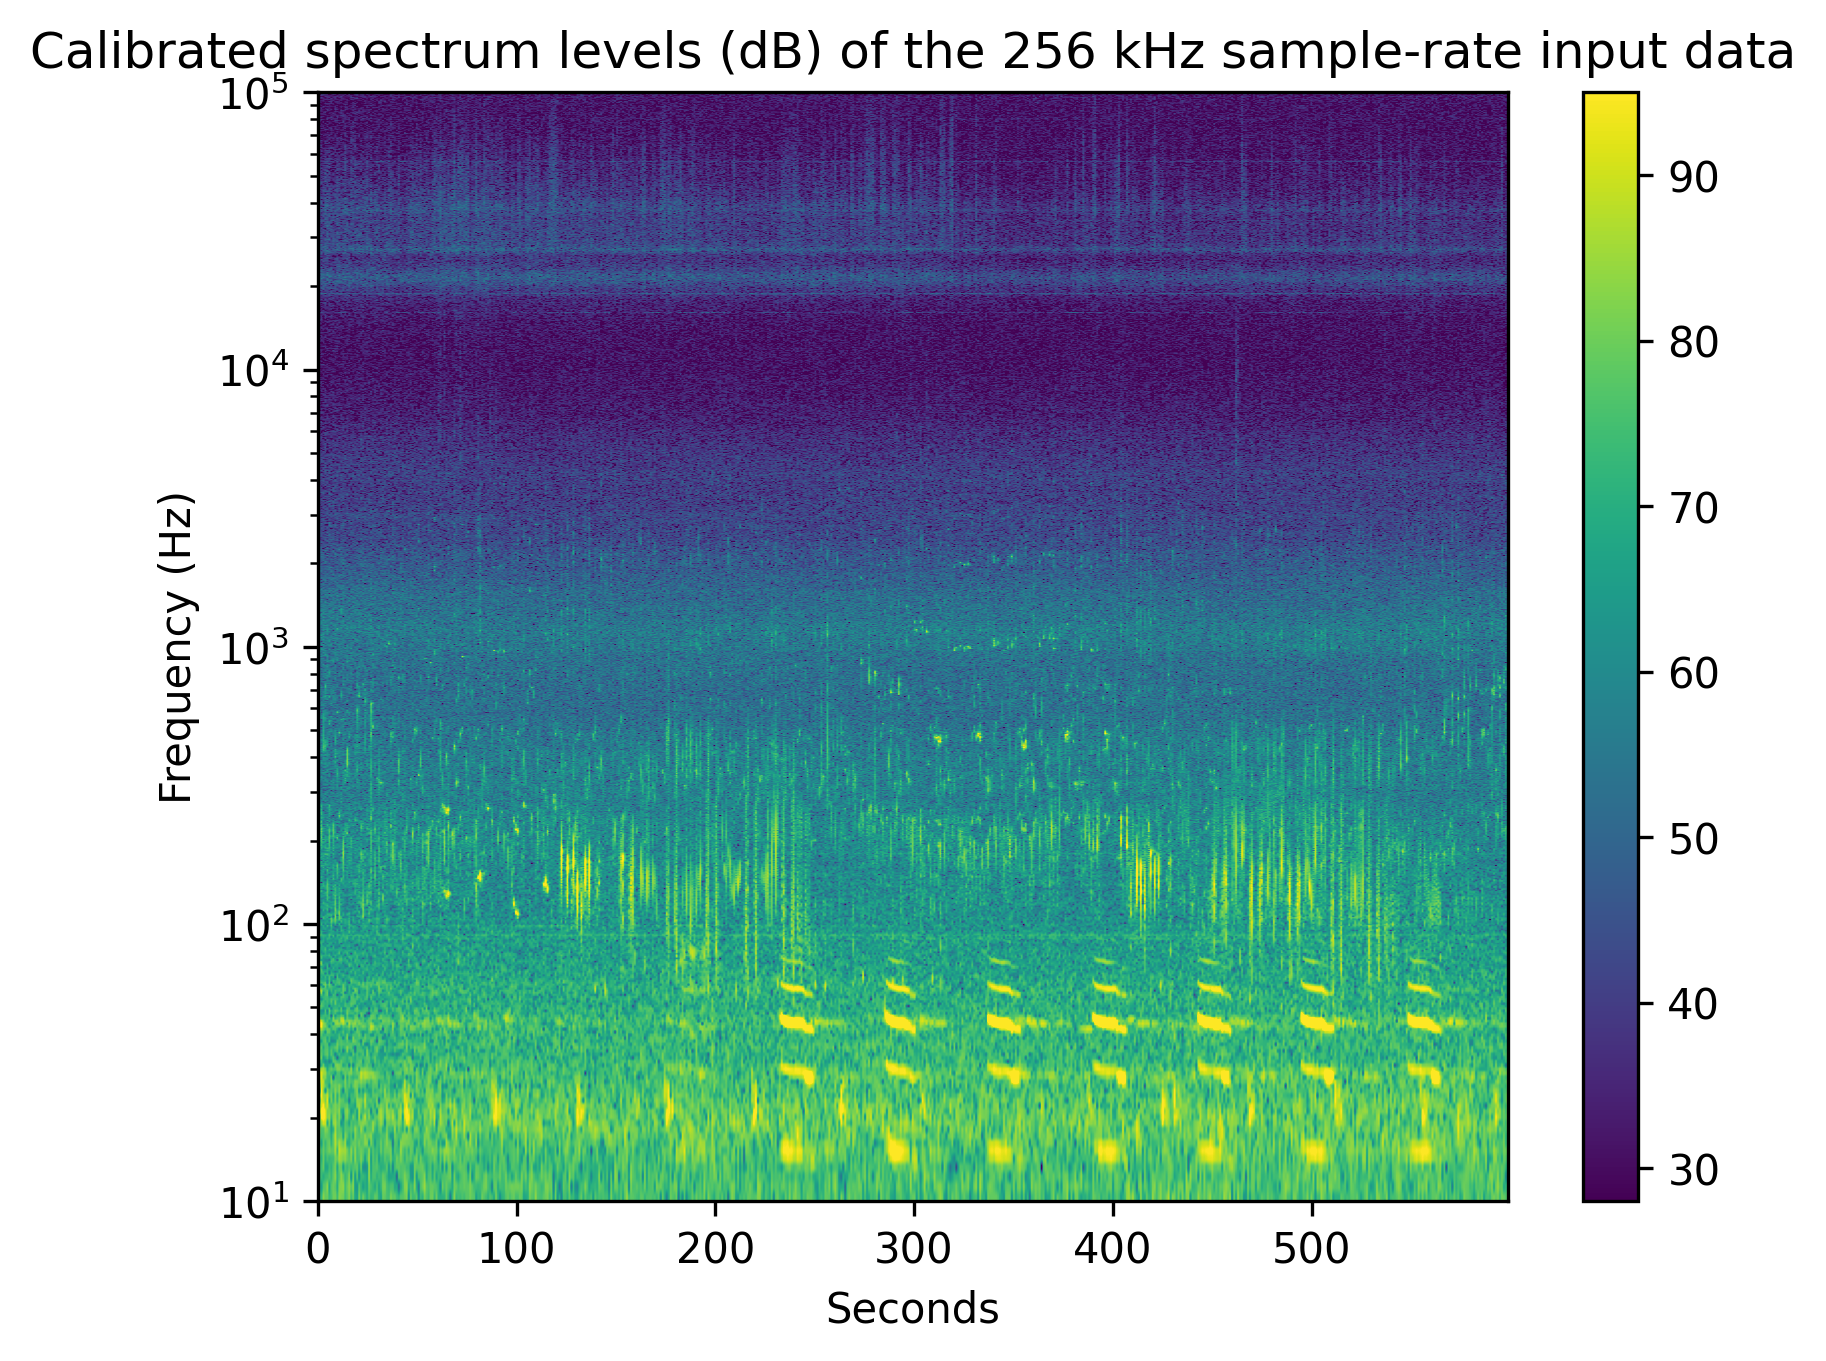

In [51]:
plt.figure(dpi=300)
Extent = [0, nseg-1, 0.0, sample_rate/2.0]
im = plt.imshow(sg_input-isensg,aspect='auto',origin='lower', extent=Extent, vmin=28,vmax=95)
plt.yscale('log')
plt.ylim(10,100000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels (dB) of the 256 kHz sample-rate input data')

## Decimate
In this example, we will decimate the raw data from the original sample rate of 256 kHz down to the final output sample rate of 2 kHz.  This decimation processing can be organized into a few steps, as defined below.

### Step 1: Allocate the decimation task to two concatenated stages.


In [52]:
samplingfreq_output_final = 64e3 # In Hz.
ratio_downsampling = int(sample_rate/samplingfreq_output_final)
#
# Allocate the decimation to two stages: ratio_downsampling = ratio_downsampling_1st_stage * ratio_downsampling_2nd_stage
# using the algorithm in R. Crochiere and L. Rabiner, L, "Optimum FIR Digital Implementations for Decimation, Interpolation, and Narrow-Band Filtering, "
# IEEE Transactions on Acoustic, Speech, and Signal Processing, ASSP-23(5), pp. 444-456, 1975.
#
ratio_BWoverNyquistfreq = 0.1 # Assuming that in the 2nd stage, the ratio of transition bandwidth over Nyquist frequency is 0.1
ratio_downsampling_1st_stage_tmp = 2.0 * ratio_downsampling *\
  (1.0-math.sqrt(ratio_downsampling*ratio_BWoverNyquistfreq/(2.0-ratio_BWoverNyquistfreq)))/\
  (2.0-ratio_BWoverNyquistfreq*(ratio_downsampling+1))
#
# Find the integer closest to ratio_downsampling_1st_stage_tmp, and assign this integer value to ratio_downsampling_1st_stage
ratio_downsampling_1st_stage = 2 # Initialized.
diff = ratio_downsampling # Initialized.
for k in range(2, ratio_downsampling):
  if (ratio_downsampling%k == 0):
    if (abs(ratio_downsampling_1st_stage_tmp-k) < diff):
      diff = abs(ratio_downsampling_1st_stage_tmp-k)
      ratio_downsampling_1st_stage = k
#
ratio_downsampling_2nd_stage = int(ratio_downsampling / ratio_downsampling_1st_stage)
samplingfreq_output_1st_stage = sample_rate / ratio_downsampling_1st_stage # Sampling frequency of the 1st-stage decimation output
#
print('Raw data sample rate = ' + str(int(sample_rate)) + ' Hz. Final output sample rate = ' + str(int(samplingfreq_output_final)) + ' Hz. Overall decimation factor = ' + str(int(ratio_downsampling)))
print('1st-stage decimator reduces sample rate from ' + str(int(sample_rate)) + ' Hz to ' + str(int(samplingfreq_output_1st_stage)) + ' Hz, at a decimation factor of ' + str(int(ratio_downsampling_1st_stage)))
print('2nd-stage decimator reduces sample rate from ' + str(int(samplingfreq_output_1st_stage)) + ' Hz to ' + str(int(samplingfreq_output_final)) + ' Hz, at a decimation factor of ' + str(int(ratio_downsampling_2nd_stage)))

Raw data sample rate = 256000 Hz. Final output sample rate = 64000 Hz. Overall decimation factor = 4
1st-stage decimator reduces sample rate from 256000 Hz to 128000 Hz, at a decimation factor of 2
2nd-stage decimator reduces sample rate from 128000 Hz to 64000 Hz, at a decimation factor of 2


###Step 2: Design the optimized windowed-sinc anti-aliasing filter in each stage.

In [53]:
def BlackmanSincFilter(samplingfreq_in, samplingfreq_out, samplingfreq_output_final):
# Blackman window parameters:
    alpha = 0.16
    a0 = (1.0-alpha)/2.0
    a1 = 0.5
    a2 = alpha/2.0
#
    lenDFT = 2**14 # Number of FFT data points. Frequency resolution = samplingfreq_in/lenDFT
    VectorDFT = np.arange(0, int(lenDFT/2), 1, int)
#
    thresh_dB_stopband = -74.0 # Stopband attenuation when using Blackman filter.
#
    if (samplingfreq_out != samplingfreq_output_final): # 1st-stage
        thresh_dB_passband = -0.1
        passfreq = samplingfreq_output_final/2.0
        stopfreq = samplingfreq_out - passfreq
# For example, in decimation 256 kHz --> 8 kHz --> 2 kHz,
# for the 1st-stage filter: samplingfreq_in = sample_rate = 256 kHz, samplingfreq_out = 8 kHz.
# passfreq = 2kHz/2 = 1 kHz. Thus the passband is from zero to 1 kHz.
# stopfreq = 8 kHz - 1 kHz = 7 kHz. Thus the stopband is from 7 kHz to 128 kHz. (4 kHz is the Nyquist frequency of the 1st-stage filter.)
# When the data is down-sampled from 256 kHz to 8 kHz,
# the passband spectrum from 4 kHz to 7 kHz is aliased and folded back to 1 kHz to 4 kHz.
# Nonetheless, this aliased spectral section (1-4 kHz) will be filtered out in the 2nd-stage decimation.
        deltafreq = 100.0 # In Hz. Resolution of the search grid.
        MLW = (stopfreq-passfreq) + np.arange(0.0,  (deltafreq*(50+1)), deltafreq, float)
# We want the MLW search range to be sufficiently wide yet not too wide in order to reduce computation.
# This range is wider for the 1st-stage filter than for the 2nd-stage filter.
# This range may need adjustment for different values of samplingfreq_in.
    else:
        thresh_dB_passband = -1.0
        bufferband = 100.0 # In Hz. Only for 2nd-stage filter. 256 kHz --> 32 kHz --> 16 kHz,
        passfreq = (samplingfreq_out/2.0) - bufferband
        stopfreq = samplingfreq_out/2.0
# For example, in decimation 256 kHz --> 8 kHz --> 2 kHz,
# for the 2nd-stage filter: samplingfreq_in = 8 kHz, samplingfreq_out = samplingfreq_output_final = 2 kHz.
# passfreq = 2kHz/2 - 100 Hz = 900 Hz. Thus the passband is from zero to 900 Hz.
# stopfreq = 2kHz/2 = 1 kHz. Thus the stopband is from 1 kHz to 4 kHz. (4 kHz is the Nyquist frequency of the 2nd-stage filter.)
        deltafreq = 10.0 # In Hz. Resolution of the search grid.
        MLW = (stopfreq-passfreq) + np.arange(0.0, (deltafreq*(20+1)), deltafreq, float)

    Cutofffreq_sinc = np.arange(passfreq, stopfreq + deltafreq, deltafreq)

    Freq = (VectorDFT/lenDFT)*samplingfreq_in
    Ind_passband = np.where(Freq <= passfreq)
    Ind_stopband = np.where(Freq >= stopfreq)

    Filterlength_Blackman_satisfactory = np.empty((len(Cutofffreq_sinc), len(MLW)))
    Filterlength_Blackman_satisfactory[:] = np.nan

    for k in range(len(MLW)):
        transitionMLW_radian = (MLW[k] / (samplingfreq_in / 2.0)) * math.pi
        filterlength_Blackman_0 = math.ceil(12.0*math.pi/transitionMLW_radian)
        if (filterlength_Blackman_0%2 == 0):
            filterlength_Blackman = filterlength_Blackman_0 + 1
        else:
            filterlength_Blackman = filterlength_Blackman_0
# We want filterlength_Blackman to be an odd number,
# so that the filter-induced delay (filterlength_Blackman-1)/2 is an integer. Used below.
        Vectortmp = np.arange(0, filterlength_Blackman)
        Vectortmp2 = Vectortmp/(filterlength_Blackman-1)
        Window_Blackman = a0 - a1*np.cos(2.0*math.pi*Vectortmp2) + a2*np.cos(4.0*math.pi*Vectortmp2)

        for m in range(len(Cutofffreq_sinc)):
            SincFun = np.sinc(2.0*(Cutofffreq_sinc[m]/samplingfreq_in)*(Vectortmp-((filterlength_Blackman-1)/2)))
            Filter_Blackman_0 = np.multiply(SincFun, Window_Blackman)
            Filter_Blackman = Filter_Blackman_0/np.sum(Filter_Blackman_0)
            DFT_filter_Blackman_0 = np.fft.fft(Filter_Blackman, lenDFT)
            DFT_filter_Blackman = DFT_filter_Blackman_0[0:int(lenDFT/2)]
            Mag_dB = 20.0*np.log10(np.abs(DFT_filter_Blackman[VectorDFT]))
            if ((min(Mag_dB[Ind_passband]) >= thresh_dB_passband) and (max(Mag_dB[Ind_stopband]) <= thresh_dB_stopband)):
                Filterlength_Blackman_satisfactory[m][k] = filterlength_Blackman

    Vec_filterlength_Blackman_satisfactory = np.reshape(Filterlength_Blackman_satisfactory, (1, (len(MLW)*len(Cutofffreq_sinc))), order='F')
    indtmp = np.nanargmin(Vec_filterlength_Blackman_satisfactory)
    ind_MLW_minfilterlength = math.floor(indtmp/len(Cutofffreq_sinc))
    ind_CutofffreqSinc_minfilterlength = indtmp - (ind_MLW_minfilterlength * len(Cutofffreq_sinc))

# Having found the optimized combination of MLW and CutofffreqSinc, now we formulate the optimal Blackman-sinc low-pass filter:
    transitionMLW_radian = (MLW[ind_MLW_minfilterlength] / (samplingfreq_in/2.0)) * math.pi
    filterlength_Blackman_0 = math.ceil(12.0*math.pi/transitionMLW_radian)
    if (filterlength_Blackman_0%2 == 0):
        filterlength_Blackman = filterlength_Blackman_0 + 1
    else:
        filterlength_Blackman = filterlength_Blackman_0

    Vectortmp = np.arange(0, filterlength_Blackman)
    Vectortmp2 = Vectortmp/(filterlength_Blackman-1)
    Window_Blackman = a0 - a1*np.cos(2.0*math.pi*Vectortmp2) + a2*np.cos(4.0*math.pi*Vectortmp2)
    SincFun = np.sinc(2.0*(Cutofffreq_sinc[ind_CutofffreqSinc_minfilterlength]/samplingfreq_in)*(Vectortmp-((filterlength_Blackman-1)/2)))
    Filter_Blackman_0 = np.multiply(SincFun, Window_Blackman)
    Filter_Blackman = Filter_Blackman_0 / np.sum(Filter_Blackman_0)
    return Filter_Blackman

Filter_1st_stage = BlackmanSincFilter(sample_rate, samplingfreq_output_1st_stage, samplingfreq_output_final)
Filter_2nd_stage = BlackmanSincFilter(samplingfreq_output_1st_stage, samplingfreq_output_final, samplingfreq_output_final)

print('Length of first stage filter: ' + str(int(len(Filter_1st_stage))))
print('Length of second stage filter: ' + str(int(len(Filter_2nd_stage))))

Length of first stage filter: 23
Length of second stage filter: 5121


/tmp/ipykernel_3760/2269792761.py:69: RuntimeWarning: divide by zero encountered in log10
  Mag_dB = 20.0*np.log10(np.abs(DFT_filter_Blackman[VectorDFT]))


###Step 3: Run the raw input data through the 1st-stage filter, downsample, then through the 2nd-stage filter, and down-sample again.

In [54]:
S_filtered_1_full = np.convolve(v, Filter_1st_stage, 'full')
S_filtered_1 = S_filtered_1_full[0:len(v)]
S_filtered_1_decimated = S_filtered_1[0:len(S_filtered_1):ratio_downsampling_1st_stage]
S_filtered_2 = np.convolve(S_filtered_1_decimated, Filter_2nd_stage, 'same');
S_filtered_2_decimated = S_filtered_2[0:len(S_filtered_2):ratio_downsampling_2nd_stage]
# salvataggio su file di S_filtered_2_decimated
output_dir = Path('media', 'audio')
output_filename = 'MARS_20180101_092406_decimated.wav'
output_filename = Path(output_dir, output_filename)

In [55]:
sf.write(output_filename, S_filtered_2_decimated, int(64e3))

### Compute and plot the spectrogram of the decimated data


{nseg} segments of length {spa} seconds in {nsec} seconds of audio
65536


Text(0.5, 1.0, 'Calibrated spectrum levels (dB) of the 2 kHz sample-rate decimated data')

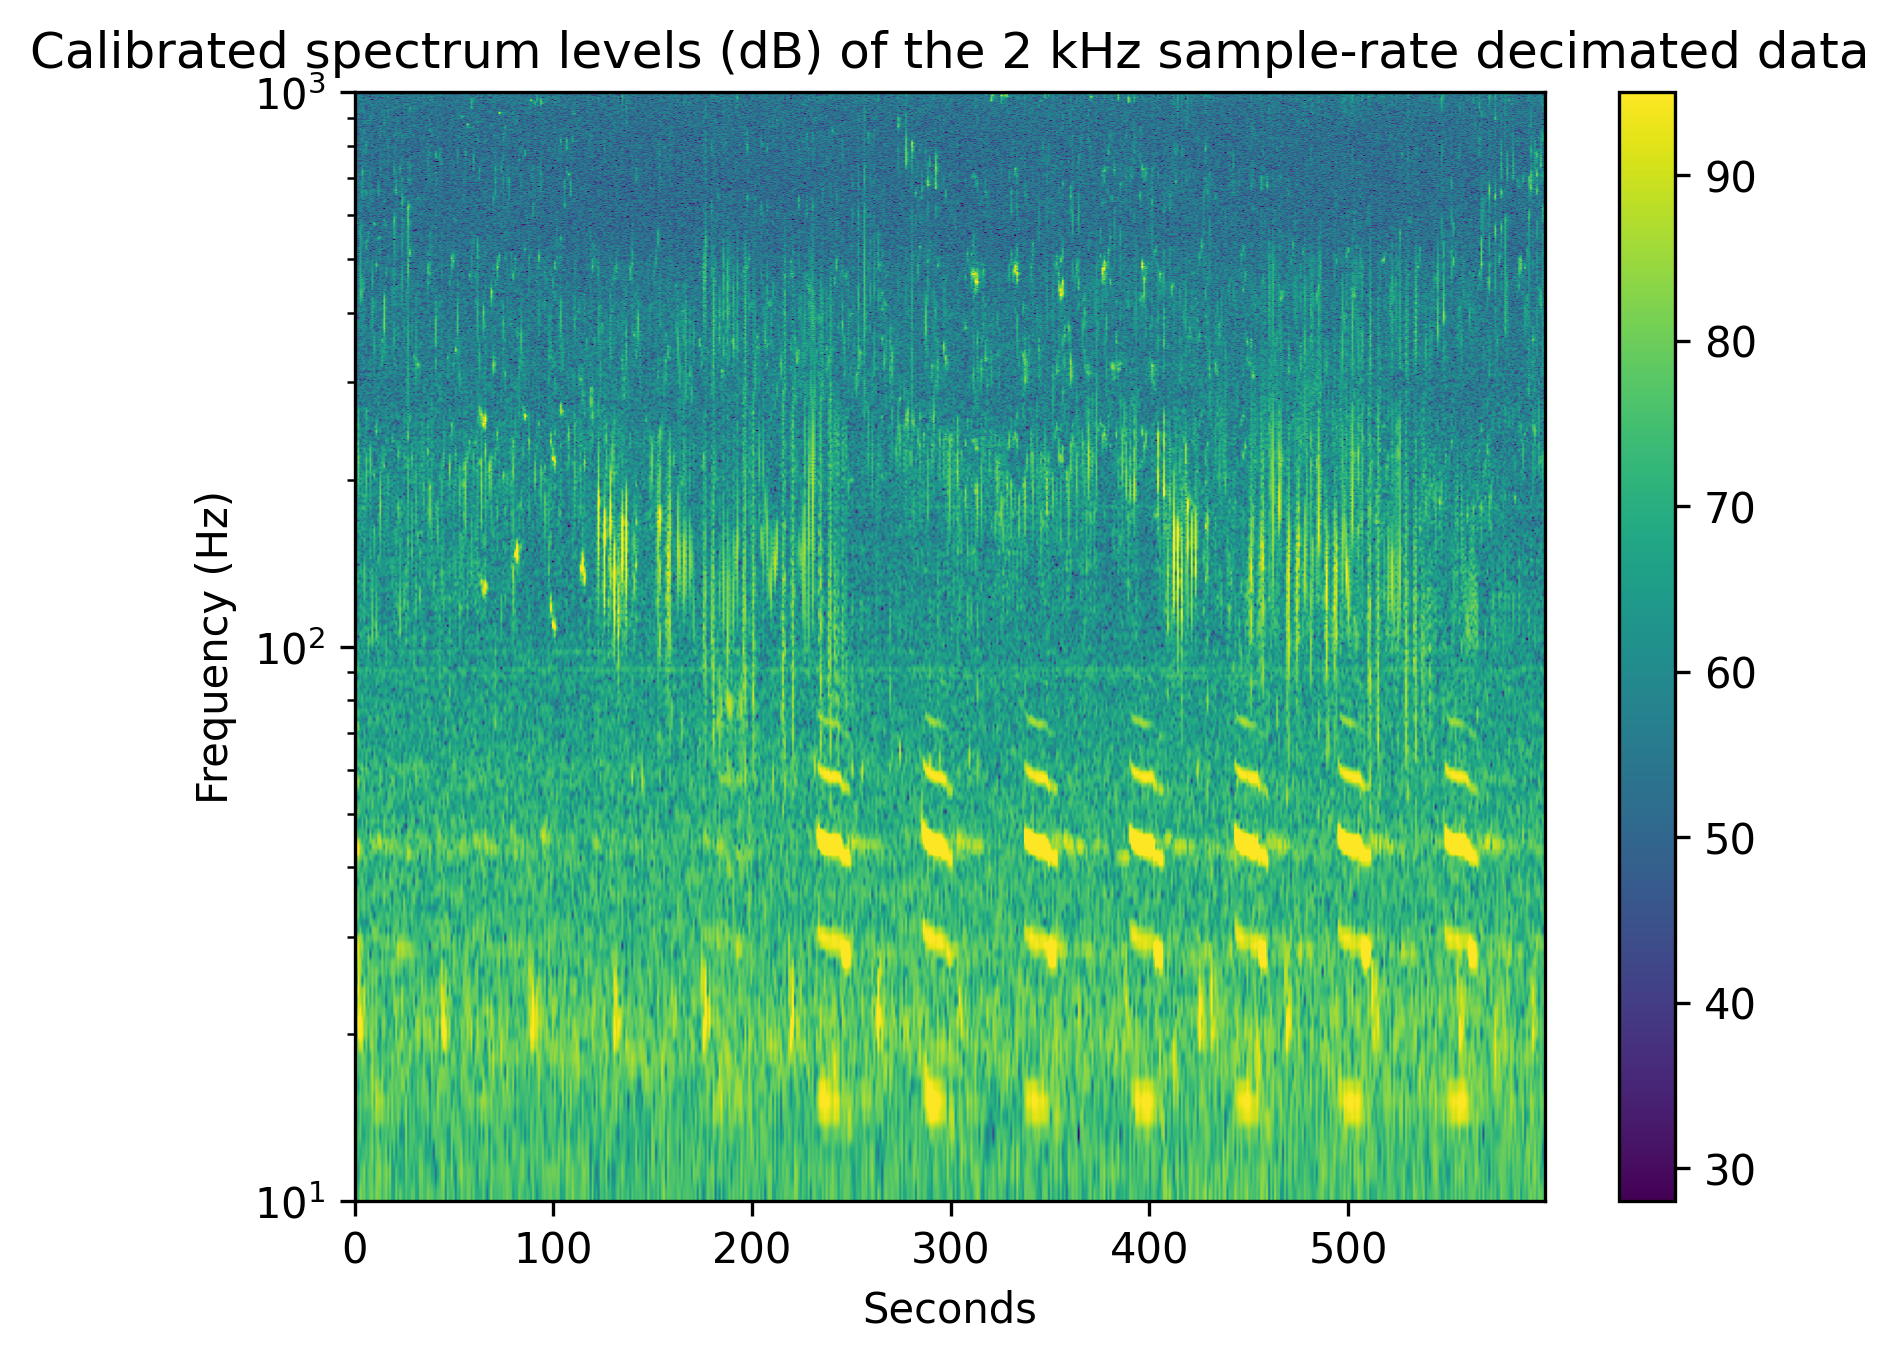

In [56]:
nsec_decimated = (S_filtered_2_decimated.size)/samplingfreq_output_final # number of seconds in vector
nseg_decimated = int(nsec_decimated/spa)
print('{nseg} segments of length {spa} seconds in {nsec} seconds of audio')
#
lenfft_decimated = 2**int(np.ceil(np.log2(samplingfreq_output_final)))
print(lenfft_decimated)
#
numDataPoints_decimated = int(samplingfreq_output_final*spa)
#
Ind_keep_decimated = np.arange(int(0), int(lenfft_decimated/2+1))
f_decimated = (Ind_keep_decimated/lenfft_decimated) * samplingfreq_output_final
#
# initialize empty LTSA
nfreq_decimated = int(lenfft_decimated/2+1)
sg_decimated = np.empty((nfreq_decimated, nseg_decimated), float)
#
# get window
w_decimated = scipy.signal.get_window('blackman', numDataPoints_decimated)
# Calculate spectrogram
for x_decimated in range(0,nseg_decimated):
  cstart_decimated = x_decimated*spa*int(samplingfreq_output_final)
  cend_decimated = (x_decimated+1)*spa*int(samplingfreq_output_final)
  psd_decimated = (np.square(np.absolute(np.fft.fft(np.multiply(S_filtered_2_decimated[cstart_decimated:cend_decimated],w_decimated), n=lenfft_decimated))))/(numDataPoints_decimated*window_correction)/samplingfreq_output_final

  psd_decimated_log10 = 10*np.log10(psd_decimated[Ind_keep_decimated])
  sg_decimated[:,x_decimated] = np.transpose(psd_decimated_log10)

  if (x == 0):
    psd_decimated_check = psd_decimated
    print("Comparing power of the decimated signal computed in the time domain versus that computed in the frequency domain:")
    print(np.mean(np.square(v[cstart:cend])))
    print(sum(psd_decimated_check)*(samplingfreq_output_final/lenfft_decimated))

isens_FreqRangeAfterDecimation = interpolate.splev(f_decimated, tck, der=0)
isensg_FreqRangeAfterDecimation = np.transpose(np.tile(isens_FreqRangeAfterDecimation,[nseg,1]))

Extent = [0, nseg_decimated-1, 0.0, samplingfreq_output_final/2.0]
plt.figure(dpi=300)
im = plt.imshow(sg_decimated-isensg_FreqRangeAfterDecimation, aspect='auto', origin='lower', extent=Extent, vmin=28,vmax=95)
plt.yscale('log')
plt.ylim(10,1e3)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels (dB) of the 2 kHz sample-rate decimated data')

###Compare PSDs of the input data and the decimated data for verification purposes

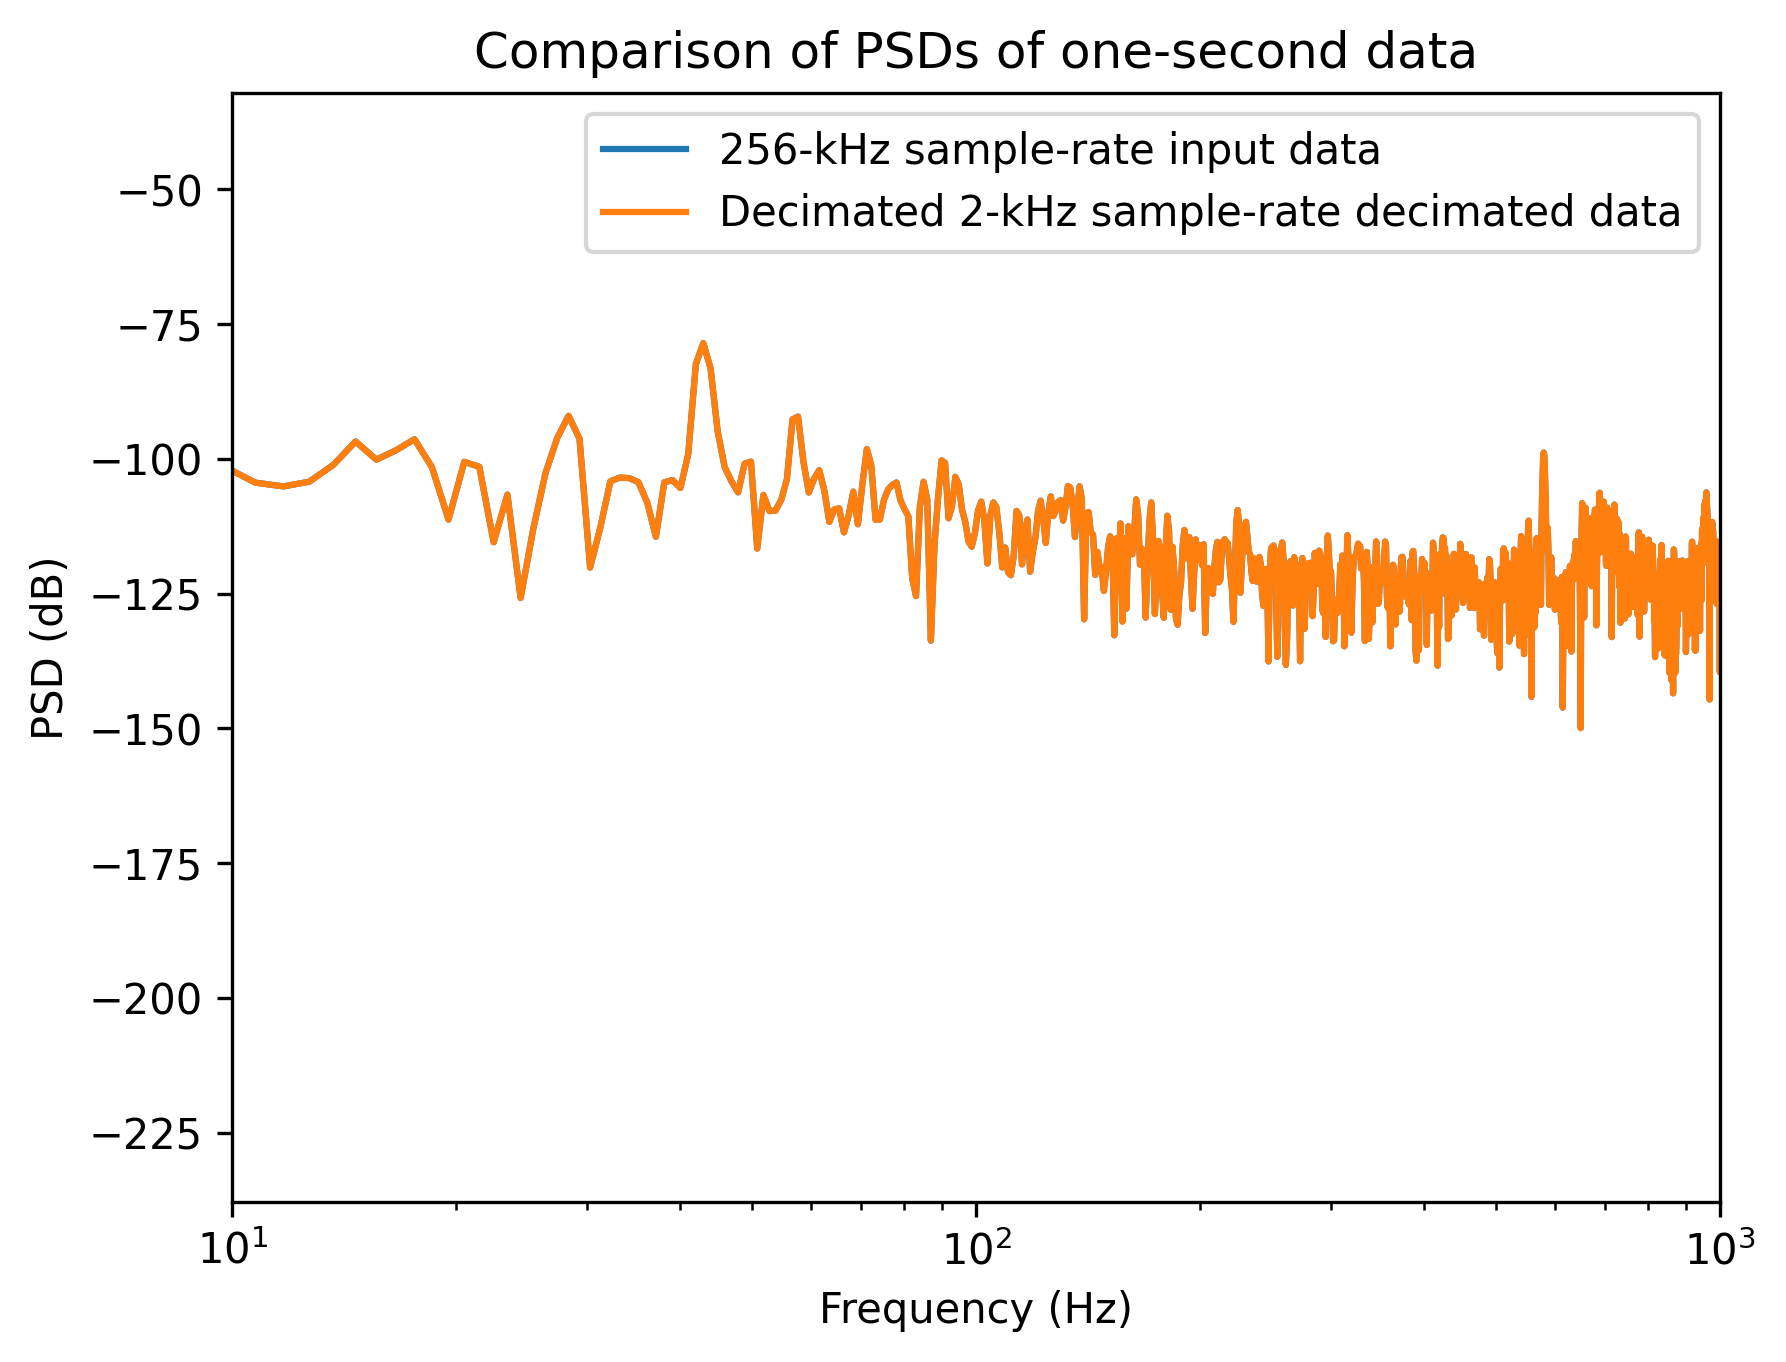

In [57]:
plt.figure(dpi=300)
plt.plot(f_decimated, sg_decimated[:,0], label='256-kHz sample-rate input data')
plt.plot(f_input, sg_input[:,0], label='Decimated 2-kHz sample-rate decimated data')
plt.xlim(10,1e3)
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.ylabel('PSD (dB)')
plt.title('Comparison of PSDs of one-second data')
plt.legend()